In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

In [2]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
'''Dynamic Programming, FCFS Simulated result'''
dp = 60940
fcfs = 45276

In [4]:
'''Establish an aircraft'''
class aircraft:

    # Initialize aircraft
    def __init__(self):
        self.seat_capacity = 100
        self.seat_type = ['Y', 'M', 'K']
        self.seat_price = {'f': 0, 'Y': 800, 'M': 500, 'K': 450}

In [5]:
''' Demand model from Balaiyan et al.'''
class demandmodel:
    
    # Initialize demand model
    def __init__(self):
        
        # inherent attributes from aircraft class
        self.aircraft = aircraft()
        self.seat_set = self.aircraft.seat_type
        self.seat_price = self.aircraft.seat_price
        
        # demand model parameters
        self.total_booking = 105
        self.market_share = 0.25
        self.gamma = 0.08426
        self.alpha = 0.001251
        self.beta = {'DFARE':-0.006, 'LOT3':-0.944}
        self.a = {'Y':{'DFARE':800, 'LOT3':1},
                  'M':{'DFARE':500, 'LOT3':1},
                  'K':{'DFARE':450, 'LOT3':1},
                 }
        self.fare_diff_avg = sum(self.seat_price.values()) / len(self.seat_price)
        for seat_type in self.a:
            self.a[seat_type]['DFARE'] = round(self.a[seat_type]['DFARE'] - self.fare_diff_avg, 2)

    # Calculate dm
    def dm(self):
        dm = self.total_booking/self.market_share
        return dm

    # Calcilate booking curve
    def booking_curve(self, RD2, RD1):
        booking_curve = math.exp(-self.gamma*RD2)-math.exp(-self.gamma*RD1)
        return booking_curve

    # find pj+1
    def find_pj1(self, seat):
        smaller_keys = [key for key in self.seat_price.keys() if key < seat]
        if smaller_keys:
            max_smaller_key = max(smaller_keys)
            pj1 = self.seat_price[max_smaller_key]
        else:
            pj1 = min(self.seat_price.values())
        return pj1

    # Multinomial logit model
    def mnl(self):
        choose_prob = {}
        value_dict = {}
        for seat in self.seat_set:
            result = {key: self.beta[key] * value for key, value in self.a[seat].items()}
            total = sum(result.values())
            value = math.exp(total)
            value_dict[seat] = value
        for seat in value_dict:
            exp_value = math.exp(value_dict[seat])
            choose_prob[seat] = exp_value / sum(math.exp(value) for value in value_dict.values())
        # print("mnl: ", choose_prob)
        return choose_prob

    # Calculate customer choice
    def customer_choice(self, seat_type):
        total_sum = 0
        choose_prob = self.mnl()
        min_key = min(self.seat_price, key=self.seat_price.get)
        p0 = self.seat_price[min_key]
        for seat in self.seat_set:
            pj = self.seat_price['Y'] # 暫時寫這樣
            pj1 = self.seat_price['M'] # 暫時寫這樣
            # print('p0: ',p0 , 'p1: ', pj, 'pj1: ', pj1)
            sum_of_set = (math.exp(-self.alpha*(pj-p0))-math.exp(-self.alpha*(pj1-p0))) * choose_prob[seat_type] 
            # print('sum of set: ', sum_of_set)
            total_sum += sum_of_set
        return total_sum

    # Calculate demand
    def formulation(self, RD2, RD1):
        dm = self.dm()
        # print('dm',dm)
        booking_curve = self.booking_curve(RD2, RD1)
        # print('booking curve: ',booking_curve)
        BR_dict = {}
        
        for seat in self.seat_set:
            # print("calculate", seat, " ing...")
            customer_choice = self.customer_choice(seat)
            # print('customer choice', customer_choice)
            BR = dm * booking_curve * customer_choice
            BR_dict[seat] = BR
            # print(' seat: ', seat, ' predicted demand model from ', RD2,' to ', RD1, 'is', BR)
        # print("total demand: ", sum(BR_dict.values()))
        return BR_dict
    
    # Plot demand result
    def plot_demand(self):
        
        # Store calculated result
        every_rd = {seat: [] for seat in model.seat_set}  
        cumulative_demand = {seat: [] for seat in model.seat_set}  
        total_demand = {seat: 0 for seat in model.seat_set}  
        cumulative_total_demand_per_rd = []  # Store each RD cumulative demand

        # Calculate all RD demand
        cumulative_total_demand = 0  # Initialize cumulative demand
        for i in range(2, max_rd+1):
            # print('i: ', i)
            BR_results = model.formulation(i, i-1)  
            total_demand_rd = sum(BR_results.values())  # Calculate demand form all rd
            cumulative_total_demand += total_demand_rd  # update cumulative total deamnd
            cumulative_total_demand_per_rd.append(cumulative_total_demand)  # append cumulative total demand
            for seat, demand in BR_results.items():  
                every_rd[seat].append(demand) 
                total_demand[seat] += demand  
                cumulative_demand[seat].append(total_demand[seat])  
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_rd), cumulative_total_demand_per_rd, label='Total Demand')
        plt.xlabel('RD')
        plt.ylabel('Total Demand')
        plt.title('Total Demand Model')
        plt.legend()
        plt.xticks(range(0, max_rd, int(max_rd/10)))
        plt.grid(True)
        plt.show()

In [6]:
'''Action space'''
class AgentActionSpace:
    def __init__(self):
        # self.action_list = [0, 1, 2, 3, 4, 5, 6, 7]
        self.action_list = [0, 1, 2, 3]
        self.n = len(self.action_list)  

    def sample(self):
        return np.random.choice(self.action_list)

    def contains(self, action):
        return action in self.action_list

In [7]:
'''Uniform distribution'''
class uniform_distribution:

    # Initialize parameters
    def __init__(self, total_demand, total_lambda):
        self.total_demand = total_demand
        self.total_lambda = total_lambda
        self.num_period = int(total_demand/total_lambda)
        self.prob = {'Bus1': 0.1, 'Bus2': 0.2, 'Leis1': 0.2, 'Leis2': 0.2, 'Leis3': 0.3}
    
    # Calculate lambda for each type of customer
    def calculate_lambda(self):
        lambda_list = []
        lambda_list.append(round(1-self.total_lambda, 2))
        for customer in self.prob:
            lambda_list.append(round(self.prob[customer] * self.total_lambda, 2)) 
        # print("lambda_list: ", lambda_list)
        return lambda_list

In [8]:
'''Establish Customer class'''
class Customer:

    ''' Initialization '''
    def __init__(self, total_demand, total_lambda):
        self.customer_type = {0: 'f', 1: 'Bus1', 2:'Bus2', 3:'Leis1', 4: 'Leis2', 5: 'Leis3'}
        self.num_customer_type = len(self.customer_type)
        self.customer_preference = {
            'f':{'Y': False, 'M': False, 'K': False},
            'Bus1': {'Y': True, 'M': False, 'K': False},
            'Bus2': {'Y': True, 'M': True, 'K': False},
            'Leis1': {'Y': False, 'M': True, 'K': False},
            'Leis2': {'Y': False, 'M': True, 'K': True},
            'Leis3': {'Y': False, 'M': False, 'K': True},
        }

        # inherent from uniform distribution class
        self.uniform_distribution = uniform_distribution(total_demand, total_lambda)
        self.arrival_rates = self.uniform_distribution.calculate_lambda() # calculate arrival rates for each customer type
        
        # inherent from aircraft class
        self.aircraft = aircraft()
        self.seat_price = self.aircraft.seat_price

    '''Customer generation'''
    def generate_customer(self):
        random_number = np.random.rand() # generate random number
        probabilities = self.arrival_rates # arrival rates list
        cumulative_probability = 0 # Use cumulative probability decide customer type
        customer_index = 0
        for probability in probabilities:
            cumulative_probability += probability
            if random_number <= cumulative_probability:
                break
            customer_index += 1
        customer_type = self.customer_type[customer_index] # return customer will buy what kind of seat   
        # print(f"random_number: {random_number}, customer_index: {customer_index}, customer_type: {customer_type}")
        return customer_type

    '''customer's preference seat under control'''
    def preference_seat(self, customer_type, seat_open):
        preferred_seats = []  
        preferences = self.customer_preference[customer_type]  
        for seat_type, preference in preferences.items():
            if preference and seat_type in seat_open:
                preferred_seats.append(seat_type)
        # print("preference seats: ", preferred_seats)
        return preferred_seats  
    
    '''customer make decision'''
    def make_decision(self, customer_type, seat_open):
        preferred_seats = self.preference_seat(customer_type, seat_open)  
        if preferred_seats:
            cheapest_seat = min(preferred_seats, key=lambda x: self.seat_price[x])
            return cheapest_seat
        else:
            return 'f'

In [9]:
'''Establish env with Single Cabin mulitiple fare classes'''
class AirlineEnvironment:
    
    '''Initialize env parameters'''
    def __init__(self, name):
        
        # name of env
        self.name = name
        
        # inherent aircraft
        self.aircraft = aircraft()
        self.seat_capacity = self.aircraft.seat_capacity # seat limitation
        self.seat_type = self.aircraft.seat_type # seat type
        
        # inherent action space class
        self.action_space = AgentActionSpace() 
        
        # inherent attributes from demand model
        self.max_rd = 20 # total selling RDs
        self.demand_model = demandmodel()
        self.total_demand = sum(self.demand_model.formulation(self.max_rd, 1).values()) # total demand from demand model
        self.total_lambda = 0.8 # total lambda from test
        self.max_period = int(self.total_demand/self.total_lambda) # total period
        
        # inherent attributes from uniform distribution class
        self.uniform_distribution = uniform_distribution(self.total_demand, self.total_lambda)
        self.arrival_rates = self.uniform_distribution.calculate_lambda() # calculate arrival rates for each customer type

        # inherent attributes from Customer class
        self.customer = Customer(self.total_demand, self.total_lambda) 
        
        # environment parameters
        self.seat_remain = self.seat_capacity # seat limitation
        self.state = np.array([self.seat_capacity, self.max_period]) # Initialize state : (num seat sold, period)
        # self.a_s_ref = {0: 'f', 1: 'Y', 2: 'M', 3: 'K', 4: 'YM', 5: 'YK', 6: 'MK', 7: 'YMK'} # action reference to seat open combination
        self.a_s_ref = {0: 'f', 1: 'Y', 2: 'YK', 3: 'YMK'}
    
    '''reset env'''
    def reset(self):
        self.seat_remain = self.seat_capacity # Initialize total seat 
        self.state = np.array([self.seat_remain, self.max_period])  # Initialize state
        return self.state
    
    '''Step'''
    def step(self, state, action):

        # print(f"Action: {action}, state: {state}")
        
        # With remaining seat
        if self.seat_remain > 0:

            # Agent choose a seat combination
            seat_open = self.a_s_ref[action]   
            # print("seat_open: ", seat_open)
            
            # Customer generation
            customer_type = self.customer.generate_customer()
            # print("customer type: ", customer_type)

            # Customer choose seat
            chosen_seat = self.customer.make_decision(customer_type, seat_open) 
            # print("chosen seat: ", chosen_seat)

            # Decide immediate revenue
            reward = self.aircraft.seat_price[chosen_seat] 

            # Update seat remain
            if reward > 0:
                self.seat_remain = self.seat_remain-1
        
        # Without remaining seat 
        else:
            # print("No remaining seat.")
            reward = 0

        # Update period
        next_time = state[1].item() - 1
        
        # Check departure or not 
        departure = (next_time <= 0)

        # update state
        state[0] = self.seat_remain
        state[1] = next_time
        return state, reward, departure

In [10]:
'''Deep Q Network'''
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(DeepQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        actions = self.fc2(x)

        return actions

In [11]:
'''Define replay buffer'''
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    # store transition to buffer
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    # sample transition from buffer
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [12]:
from torch.distributions import Categorical


''' Define DQN agent'''
class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min, eps_dec, replace):
        self.gamma = gamma # time discount gamma
        self.epsilon = epsilon # epilson-greedy hyperparameter eplison
        self.lr = lr # learning rate
        self.n_actions = n_actions # number of action
        self.input_dims = input_dims # number of state
        self.batch_size = batch_size # batch size of sample memory
        self.eps_min = eps_min # minimum of hyperparameter epilson
        self.eps_dec = eps_dec # epilson decay rate, higher represent slower decay
        self.replace_target_cnt = replace # frequence of replace target network 
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        self.memory = ReplayBuffer(mem_size, (input_dims,), n_actions) # Replay buffer
        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims) # Target network
        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims) # Policy network

    # # agent choose action
    # def choose_action(self, observation):
    #     if np.random.random() > self.epsilon: # exploit: selection max value column
    #         state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
    #         actions = self.q_eval.forward(state)
    #         print("choose action(actions): ", actions)
    #         action = T.argmax(actions).item()
    #     else: # explore: randomly select aciton
    #         action = np.random.choice(self.action_space)
    #     return action

    # # agent choose action
    # def choose_action(self, observation):
    #     state = T.tensor([observation], dtype=T.float).to(self.q_eval.device)
    #     actions = self.q_eval.forward(state)
    
    #     # Apply mask to logits or q-values
    #     actions_masked = actions.clone()
    #     actions_masked[:, :3][state[:, 1] > 100] = float('-inf')  # Set logits corresponding to masked actions to negative infinity
    
    #     print("choose action(actions_masked): ", actions_masked)
    
    #     if np.random.random() > self.epsilon:  # Exploit
    #         # Check if there are any allowed actions
    #         if torch.isinf(actions_masked).all():
    #             action = np.random.choice(self.action_space)  # If all actions are masked, choose randomly
    #         else:
    #             action = T.argmax(actions_masked).item()  # Choose action with highest Q-value among allowed actions
    #     else:  # Explore: randomly select action without applying mask
    #         action = np.random.choice(actions_masked)
    
    #     return action

    # agent choose action
    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.q_eval.device)
        actions = self.q_eval.forward(state)
    
        # Apply mask to logits or q-values
        actions_masked = actions.clone()
        actions_masked[:, :3][state[:, 1] > 100] = float('-inf')  # Set logits corresponding to masked actions to negative infinity
    
        print("choose action(actions_masked): ", actions_masked)
    
        if np.random.random() > self.epsilon:  # Exploit
            # Check if there are any allowed actions
            if torch.isinf(actions_masked).all():
                action_probs = torch.ones_like(actions_masked) / actions_masked.size(-1)  # Uniform distribution if all actions are masked
            else:
                action_probs = F.softmax(actions_masked, dim=-1)  # Calculate action probabilities
        else:  # Explore: sample from masked action distribution
            action_probs = F.softmax(actions_masked, dim=-1)  # Calculate action probabilities
        
        action_dist = Categorical(action_probs)  # Create a categorical distribution
        action_idx = action_dist.sample()  # Sample an action from the distribution
        action = action_idx.item()  # Convert action index to numpy array
     
        return action


    # store transition
    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    # sample memory
    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)
        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)
        return states, actions, rewards, states_, dones

    # update parameter of target network
    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    # decrease value of epilson
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    # optimizer model
    def learn(self):

        if self.memory.mem_cntr < self.batch_size: # check whether have enough memory
            return

        self.q_eval.optimizer.zero_grad() # diminish previous gradient

        self.replace_target_network()

        # sample the transitions for training the Q value
        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size) # Shape of tensor = batch_size

        # # 應用遮罩以限制動作 1 和 2
        # mask = T.ones_like(actions)
        # print('actions: ', actions)
        # print('mask: ', mask)
        # mask[states[:, 1] > 100] = 0  # 當 state[1] > 100 時，將動作 1 和 2 的遮罩設為 0
        # print('mask renew: ',mask)
        
        q_pred = self.q_eval.forward(states)[indices, actions] # estimated q value
        q_next = self.q_next.forward(states_).max(dim=1)[0] # estimated q value for next state
        print('q_pred: ', q_pred)
        print('q_next: ', q_next)

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next # immediate reward + gamma * future q-value

        print('q_target: ', q_target)

        # Back proporgate loss
        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

In [13]:
# Initialize Training parameters
num_episodes = 2
DQN_total_revenues = []
DQN_cumulative_average = []
DQN_per_50_avg = []

env = AirlineEnvironment("Single route parallel flight.v0")
agent = DQNAgent(gamma=0.95, epsilon=1, lr=0.0001,
                 input_dims=len(env.state),
                 n_actions=env.action_space.n, mem_size=300000, eps_min=0.1,
                 batch_size=32, replace=1000, eps_dec=1e-5)

n_step = 0
best_score = 0

# Start Training
for episode in range(1, num_episodes+1):
    
    # Initialize environment
    print("---------- Episode ", episode, "-----------")
    observation = env.reset()
    total_revenue = 0 # Initialize total revenue
    departure = None
    
    while not departure:
        
        print("------- step " , env.max_period - n_step," ---------")
        
        # agent select action
        action = agent.choose_action(observation)
        print("action", action)

        # env return observation
        observation_, reward, departure = env.step(observation, action)
        # print("observation_: ", observation, "reward: ",  reward, "departure: ", departure)
        total_revenue += reward # Update total revenue

        # agent memorize transition
        agent.store_transition(observation, action, reward, observation_, departure)
        agent.learn()

        # Move on to the next state
        observation = observation_ 
        n_step += 1

    if total_revenue > best_score:
        best_score = total_revenue
        
    DQN_total_revenues.append(total_revenue) 
    DQN_per_50_avg.append(np.mean(DQN_total_revenues[-50:])) 
    DQN_cumulative_avg = sum(DQN_total_revenues) / (episode)
    DQN_cumulative_average.append(DQN_cumulative_avg)
    print('Episode:',episode ,'Total Revenue:', total_revenue,
             'Cumulative average %.1f' % DQN_cumulative_avg, 'best score:', best_score,
            'epsilon %.2f' % agent.epsilon, 'steps', n_step)

---------- Episode  1 -----------
------- step  193  ---------
choose action(actions_masked):  tensor([[   -inf,    -inf,    -inf, 32.9489]], device='cuda:0',
       grad_fn=<CopySlices>)
action 3
------- step  192  ---------
choose action(actions_masked):  tensor([[   -inf,    -inf,    -inf, 32.7830]], device='cuda:0',
       grad_fn=<CopySlices>)
action 3
------- step  191  ---------
choose action(actions_masked):  tensor([[   -inf,    -inf,    -inf, 32.6170]], device='cuda:0',
       grad_fn=<CopySlices>)
action 3
------- step  190  ---------
choose action(actions_masked):  tensor([[   -inf,    -inf,    -inf, 32.4532]], device='cuda:0',
       grad_fn=<CopySlices>)
action 3
------- step  189  ---------
choose action(actions_masked):  tensor([[   -inf,    -inf,    -inf, 32.2761]], device='cuda:0',
       grad_fn=<CopySlices>)
action 3
------- step  188  ---------
choose action(actions_masked):  tensor([[   -inf,    -inf,    -inf, 32.1119]], device='cuda:0',
       grad_fn=<CopySlices

C:\Users\User\AppData\Local\Temp\ipykernel_38144\3808828168.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  state = T.tensor([observation], dtype=T.float).to(self.q_eval.device)


------- step  161  ---------
choose action(actions_masked):  tensor([[   -inf,    -inf,    -inf, 45.1559]], device='cuda:0',
       grad_fn=<CopySlices>)
action 3
q_pred:  tensor([50.2614, 52.8593, 45.7401, 49.1396, 48.8486, 50.5524, 45.1559, 46.8753,
        49.4095, 51.1344, 46.5914, 52.5716, 47.4435, 52.2863, 45.4480, 52.0010,
        54.0078, 53.1520, 49.6848, 48.5642, 47.7197, 49.9704, 53.4202, 44.8638,
        51.7157, 47.1593, 46.0311, 51.4253, 50.8434, 48.0038, 53.7130, 46.3013],
       device='cuda:0', grad_fn=<IndexBackward0>)
q_next:  tensor([35.2831, 38.1797, 31.2698, 34.4779, 34.1462, 35.6124, 30.6122, 32.3387,
        34.5488, 36.2702, 32.0057, 37.8538, 33.0092, 37.5328, 30.9384, 37.2170,
        39.2387, 38.5079, 34.6197, 33.8145, 33.0801, 34.9514, 38.5816, 30.2860,
        36.9014, 32.6775, 31.6029, 36.5858, 35.9413, 33.4119, 38.9096, 31.6726],
       device='cuda:0', grad_fn=<MaxBackward0>)
q_target:  tensor([483.5190, 536.2707, 479.7063,  32.7540, 482.4389, 533.8318, 

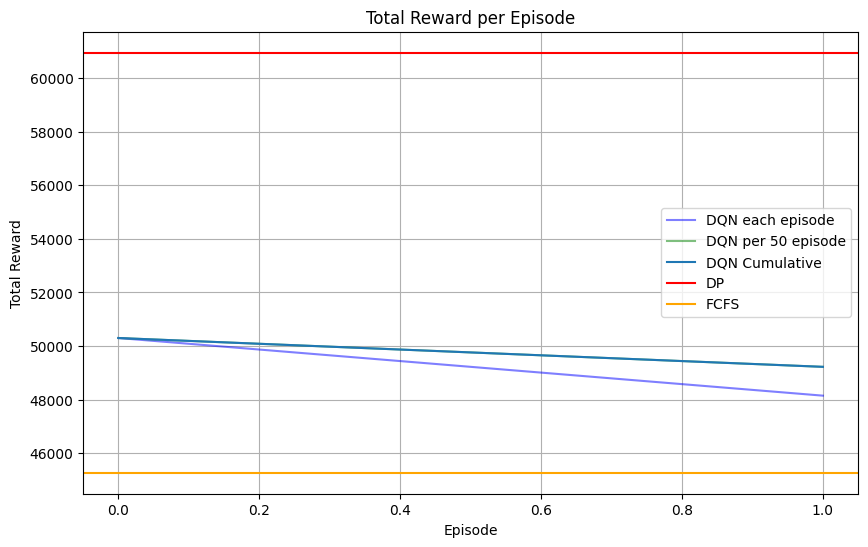

In [14]:
# Plot results
plt.figure(figsize=(10, 6))  
plt.plot(range(num_episodes), DQN_total_revenues, label='DQN each episode', alpha=0.5, color='b')
plt.plot(range(num_episodes), DQN_per_50_avg, label='DQN per 50 episode', alpha=0.5, color='green')
plt.plot(range(num_episodes), DQN_cumulative_average, label='DQN Cumulative')
plt.axhline(y=dp, color='r', label='DP')
plt.axhline(y=fcfs, color='orange', label='FCFS')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()  
plt.grid(True)
plt.show()